In [1]:
import sys
sys.path.insert(0, "..")

import aesara.tensor as at
import numpy as np
import pandas as pd

from aesara.tensor import TensorVariable

from clv import *

import pymc as pm

import matplotlib.pyplot as plt
import arviz as az

In [2]:
rng = np.random.RandomState(seed=34)
T = 10
T0 = 0

# individual-level model
lam = 0.5; p = 0.3

# random chosen individual model
a = b = alpha = r = 2

size = (5, 3)

In [3]:
individual_level_data = individual_level_clv.rng_fn(rng, lam, p, T, T0, size=[1000,])

In [4]:
with pm.Model() as model:

    λ = pm.Gamma(name="λ", alpha=0.1, beta=0.1)
    π = pm.Beta(name="π", alpha=1, beta=1)
    
    clv = IndividualLevelCLV(
        name="individual-level-clv",
        lam=λ,
        p=π,
        T=10,
        T0=0,
        observed=individual_level_data,
    )
    
    trace = pm.sample(draws=10000, chains=1, tune=5000)

Sequential sampling (1 chains in 1 job)
NUTS: [λ, π]


Sampling 1 chain for 5_000 tune and 10_000 draw iterations (5_000 + 10_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


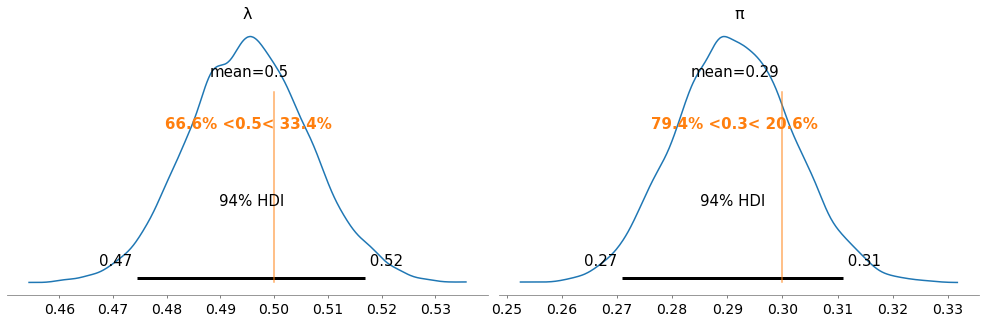

In [5]:
_ = az.plot_posterior(trace, ref_val=[0.5, 0.3])
plt.tight_layout()

In [6]:
random_individual_data = random_individual_clv.rng_fn(rng, a, b, alpha, r, T, T0, size=[1000,])

In [7]:
with pm.Model() as model_full:

    # hyper priors for the Gamma params    
    a = pm.HalfNormal(name="a", sigma=10)
    b = pm.HalfNormal(name="b", sigma=10)

    # hyper priors for the Beta params
    alpha = pm.HalfNormal(name="alpha", sigma=10)
    r = pm.HalfNormal(name="r", sigma=10)
    
    clv = RandomIndividualCLV(
        name="random-individual-clv",
        a=a,
        b=b,
        r=r,
        alpha=alpha,
        T=T,
        T0=0,
        observed=random_individual_data,
    )
    
    trace = pm.sample(draws=10000, chains=1, tune=5000)

Sequential sampling (1 chains in 1 job)
NUTS: [a, b, alpha, r]


Sampling 1 chain for 5_000 tune and 10_000 draw iterations (5_000 + 10_000 draws total) took 49 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


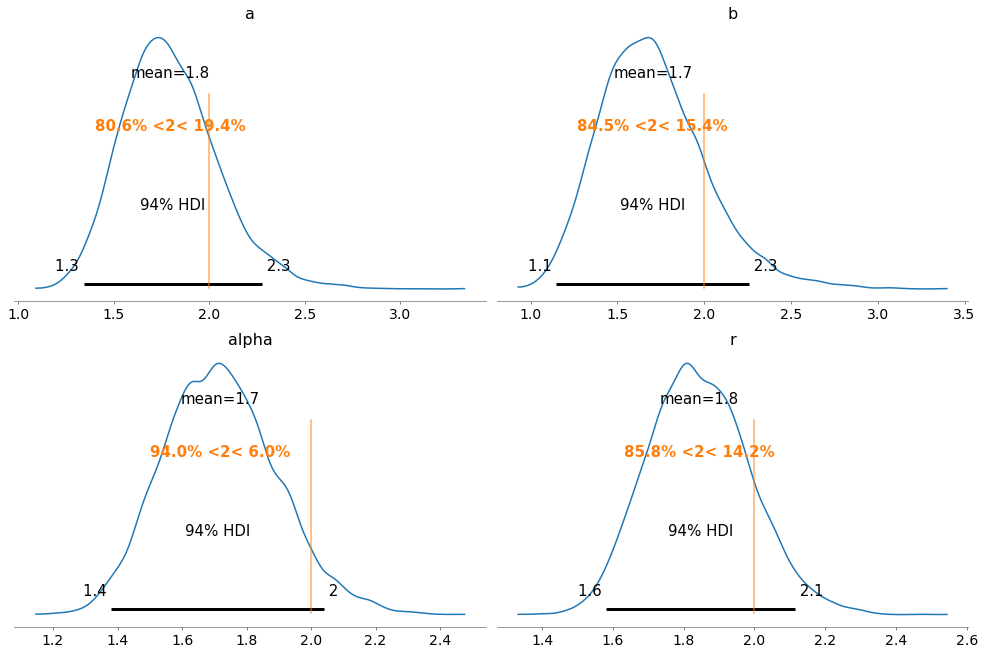

In [8]:
_ = az.plot_posterior(trace, grid=(2, 2), ref_val=2)
plt.tight_layout()

In [9]:
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.datasets import load_dataset

cdnow_transactions = load_dataset(
    'CDNOW_sample.txt', 
    header=None, 
    delim_whitespace=True, 
    names=['customer_id', 'customer_index', 'date', 'quantity', 'amount'],
    converters={'date': lambda x: pd.to_datetime(x, format="%Y%m%d")}
)


rfm = summary_data_from_transaction_data(
    cdnow_transactions,
    "customer_id",
    "date",
    observation_period_end=pd.to_datetime("1997-09-30"),
    freq='W'
)

frequency = rfm["frequency"].to_numpy()
tx = rfm["recency"].to_numpy()
T = rfm["T"].to_numpy()